In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

In [2]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')
prod_list = isee_machine.ProductNum.unique()

# prod_list[0] 제품에 대해서만 분석
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]    

analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 
isee_machine['NG_Label'] = isee_machine['NG'] + isee_machine['NG5']

# # combined_label== 1인것을 정상으로 편입, 하나씩 낮춰줌
# isee_machine['combined_label'] = [x-1 if x>1 else x for x in isee_machine['combined_label']] 
# # 원래 combined_label== 3,4,5 인 것을 위험군으로 합침
# isee_machine['combined_label'] = [2 if x>=2 else x for x in isee_machine['combined_label']]

# combined_label에서 lof_label 빼고, svm_label 넣기
isee_machine['combined_label'] = isee_machine['K_mahala_label'] + isee_machine['mahala_label'] + isee_machine['gmm_label'] +isee_machine['IF_label']

# 원래 combined_label== 1,2,3,4,5 인 것을 위험군으로 합침
isee_machine['combined_label'] = [1 if x>=3 else 0 for x in isee_machine['combined_label']]

In [3]:
df = isee_machine[isee_machine.CycleNum==64].reset_index(drop=True)

X = np.array(df[analy_col])

In [16]:
model = hmm.GaussianHMM(3, 'diag', n_iter=100)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=100, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [17]:
Z2 = model.predict(X)

In [18]:
df['hmm_label'] = Z2

In [19]:
#isee_machine.to_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label_hmm.csv')

In [20]:
df['hmm_label'].sum()

239

In [21]:
import matplotlib.pyplot as plt

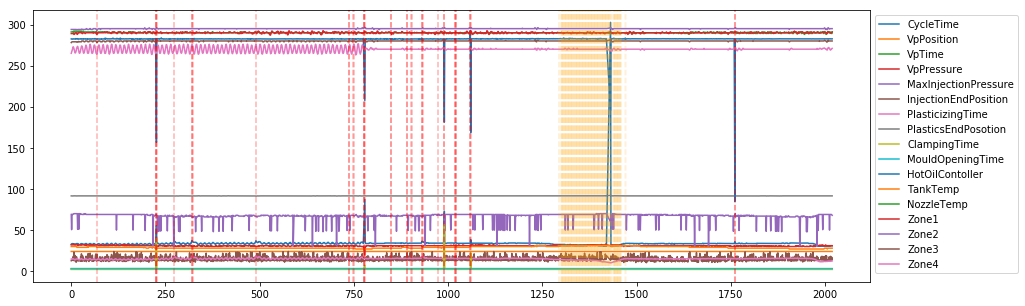

In [26]:
df[analy_col].plot(figsize=(15,5)).legend(bbox_to_anchor=(1, 1))

for xc in df[df.hmm_label==1].index.tolist():    
    plt.axvline(x=xc, color='orange', linestyle='--', alpha=0.1)
    
for xc in df[df.hmm_label==2].index.tolist():    
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.3)

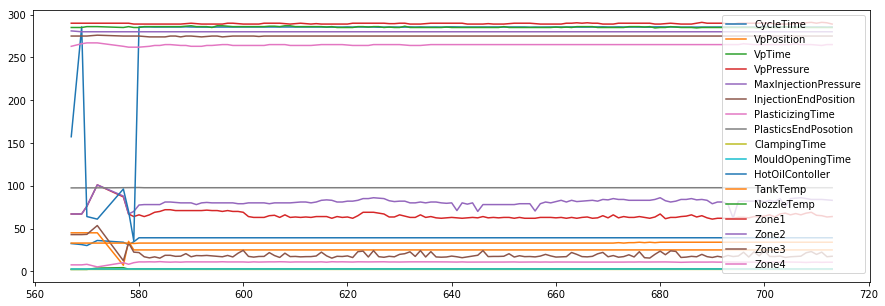

In [146]:
isee_machine[isee_machine.CycleNum==5][analy_col].plot(figsize=(15,5))

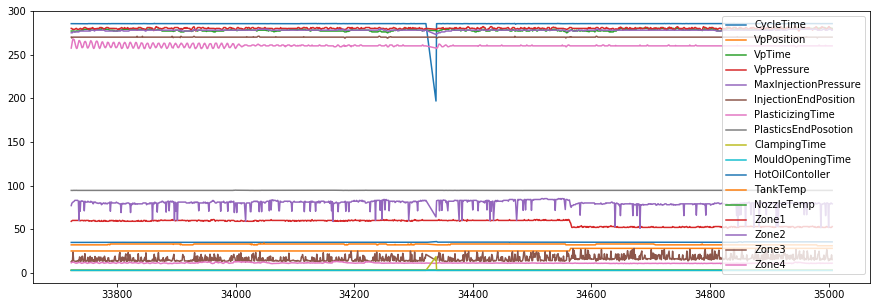

In [78]:
isee_machine[isee_machine.CycleNum==47][analy_col].plot(figsize=(15,5))

In [60]:
isee_machine.groupby('CycleNum').sum()['hmm_label']

CycleNum
1        0
3        0
4        6
5       13
6       70
7       55
8       34
9      116
10      26
11      96
12       2
13       0
30       5
31       0
32       7
33      82
34      68
35       3
36       7
37      48
38       2
39      14
40      41
41       0
43       3
44       0
45       0
46       0
47      17
48       0
49       4
50      38
51     158
52      23
53       3
54      36
55      13
56     436
57     271
59     291
60     261
62     489
63     221
64    2020
65     234
66     125
67     285
68     307
69    7339
70     375
Name: hmm_label, dtype: int32

In [ ]:
from hmmlearn.hmm import GaussianHMM
 
def fitHMM(Q, nSamples):
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=2, n_iter=1000).fit(np.reshape(Q,[len(Q),1]))
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(np.reshape(Q,[len(Q),1]))
 
    # find parameters of Gaussian HMM
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(np.reshape(Q,[len(Q),1]))
 
    # generate nSamples from Gaussian HMM
    samples = model.sample(nSamples)
 
    # re-organize mus, sigmas and P so that first row is lower mean (if not already)
    if mus[0] > mus[1]:
        mus = np.flipud(mus)
        sigmas = np.flipud(sigmas)
        P = np.fliplr(np.flipud(P))
        hidden_states = 1 - hidden_states
 
    return hidden_states, mus, sigmas, P, logProb, samples
 
# load annual flow data for the Colorado River near the Colorado/Utah state line
AnnualQ = np.loadtxt('AnnualQ.txt')
 
# log transform the data and fit the HMM
logQ = np.log(AnnualQ)
hidden_states, mus, sigmas, P, logProb, samples = fitHMM(logQ, 100)